In [ ]:
%load_ext autoreload
%autoreload 2

In [90]:
import os

from pathlib import Path

import matplotlib.pyplot as plt
import motorlab as ml
import numpy as np
import seaborn as sns
import yaml

In [ ]:
os.chdir(Path().resolve().parent)

In [ ]:
sessions = ml.config.gbyk_sessions[:1]

In [ ]:
poses = dict()
trials = dict()

for session in sessions:
    POSES_DIR = Path("data/gbyk/") / session / "poses"
    poses_ = ml.data.load_from_memmap(POSES_DIR)
    poses_ = ml.poses.change_representation(
        poses_,
        "centered",
        "gbyk",
    )
    poses[session] = poses_
    trials[session] = dict()
    trials_dir = Path(f"data/gbyk/{session}/trials/")
    for i, meta_trial in enumerate(sorted(trials_dir.iterdir())):
        trials[session][i] = {
            "choice": None,
            "start": None,
            "end": None,
            "type": None,
        }
        with open(meta_trial, "r") as f:
            meta_dict = yaml.safe_load(f)
            start = int(meta_dict["first_frame_idx"] // 50)
            end = start + int(meta_dict["num_frames"] // 50)
            trials[session][i]["start"] = start
            trials[session][i]["end"] = end
            trials[session][i]["choice"] = meta_dict["choice"]
            trials[session][i]["type"] = meta_dict["type"]

In [ ]:
test = ml.poses.compute_trunk(poses_, "gbyk")
kps_to_exclude = ["r_eye", "r_ear", "l_eye", "l_ear", "nose", "head", "e_tail"]
idxs = [ml.poses.keypoints_dict["gbyk"][kp] for kp in kps_to_exclude]
test = test.reshape(-1, 21, 3)
test[:, idxs, :] = np.nan
test = test.reshape(-1, 63)

In [ ]:
%matplotlib widget
s, e = trials[session]["R"][0]
ml.plot.poses3d(
    test[s:e],
    # poses[session][s:e],
    "gbyk",
    # return_fig=True,
    save_path="plots/trunk_centered.gif",
)

In [ ]:
runs = {
    "allocentric": 20250718155104,
    "centered": 20250718160430,
    "egocentric": 20250718194301,
    "trunk": 20250718210623,
    "head": 20250721174735,
    # "pc": 20250721180841,
}

In [88]:
results_dict = {
    "representation": [],
    "monkey": [],
    "type": [],
    # "x_acc": [],
    "acc": [],
    "direction": [],
}

for representation, run in runs.items():
    config_path = Path(f"config/poses_to_position/{run}.yaml")

    with open(config_path, "r") as f:
        config = yaml.safe_load(f)
        config["dataset"]["entire_trials"] = True
        config["dataset"]["batch_size"] = 1

    model = ml.model.load(config, is_train=False)
    test_intervals, train_intervals, _ = ml.intervals.get_tiers_intervals(
        config["DATA_DIR"],
        config["sessions"],
        config["experiment"],
        include_trial=config["intervals"].get("include_trial", True),
        include_homing=config["intervals"].get("include_homing", True),
        include_sitting=config["intervals"].get("include_sitting", True),
    )
    data_dict = ml.data.load_all(config, train_intervals)
    datasets = ml.datasets.load_datasets(
        data_dict,
        test_intervals,
        ml.utils.list_modalities(config["in_modalities"]),
        ml.utils.list_modalities(config["out_modalities"]),
        entire_trials=True,
    )
    dataloaders = ml.datasets.load_dataloaders(
        datasets, config["dataset"]["batch_size"], is_train=False
    )
    _, gts, preds = ml.model.iterate_entire_trials(model, dataloaders, 100)

    for session in config["sessions"]:
        for i in range(len(test_intervals)):
            acc = ml.metrics.mse(gts[session][i], preds[session][i])
            results_dict["representation"].append(representation)
            results_dict["monkey"].append(session[:3])
            results_dict["type"].append(test_intervals[session][i].type)
            results_dict["direction"].append(
                test_intervals[session][i].direction
            )
            results_dict["acc"].append(acc)

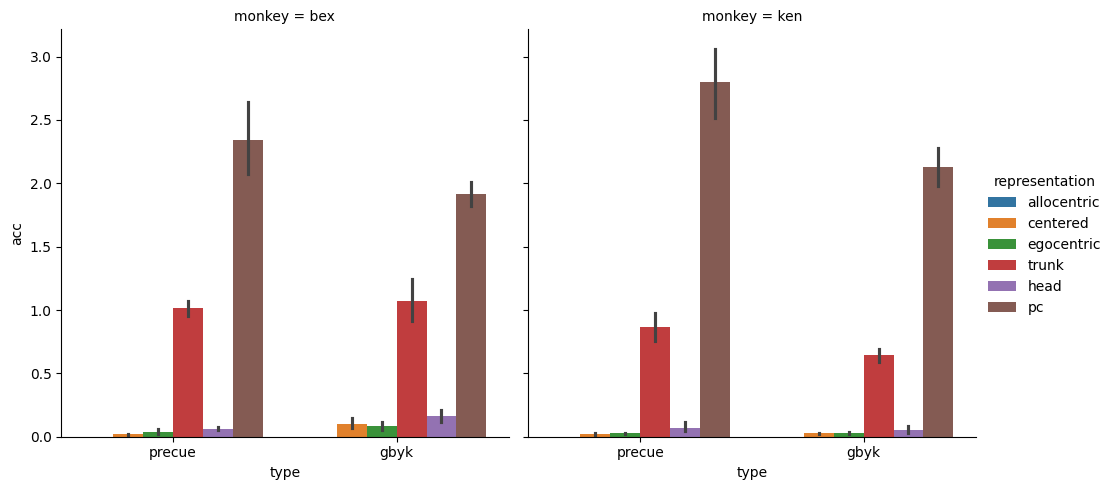

In [109]:
%matplotlib inline
g = sns.catplot(
    data=results_dict,
    col="monkey",
    x="type",
    y="acc",
    hue="representation",
    kind="bar",
)